In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [4]:
def list_reader(txt_path):
    txt_file = open(txt_path, 'r')
    return_list = []
    for line in txt_file.readlines():
        name = line.strip().split(' ')[0].strip()
        return_list.append(name)
    return return_list

In [5]:
train_path = "/kaggle/input/oxford-pet/annotations/annotations/trainval.txt"
test_path = "/kaggle/input/oxford-pet/annotations/annotations/test.txt"

train_list = list_reader(train_path)
test_list = list_reader(test_path)

In [6]:
def get_img_label_path(name_list, img_dir, label_dir):
    img_list = []
    label_list = []
    for name in tqdm(name_list):
        img_list.append(os.path.join(img_dir, name + ".jpg"))
        label_list.append(os.path.join(label_dir, name + ".png"))
    return img_list, label_list

In [7]:
image_dir = "/kaggle/input/oxford-pet/images/images"
map_dir = "/kaggle/input/oxford-pet/annotations/annotations/trimaps"

train_img, train_label = get_img_label_path(train_list, image_dir, map_dir)
test_img, test_label = get_img_label_path(test_list, image_dir, map_dir)

100%|██████████| 3669/3669 [00:00<00:00, 293010.31it/s]


In [15]:
def read_image(img_path):
    img = tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)
    img = tf.image.resize(img, (160, 160)) / 255.
    return img

# Pixel Annotations: 0: Foreground 1:Background 2: Not classified
def read_map(img_path):
    label_map = tf.image.decode_png(tf.io.read_file(img_path), channels=1) - 1
    label_map = tf.image.resize(label_map, (160, 160), method="nearest")
    return label_map

def get_data(img_path, label_path):
    img = read_image(img_path)
    label = read_map(label_path)
    
    return img, label

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=3000)
train_ds = train_ds.map(get_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_img, test_label)).map(get_data)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

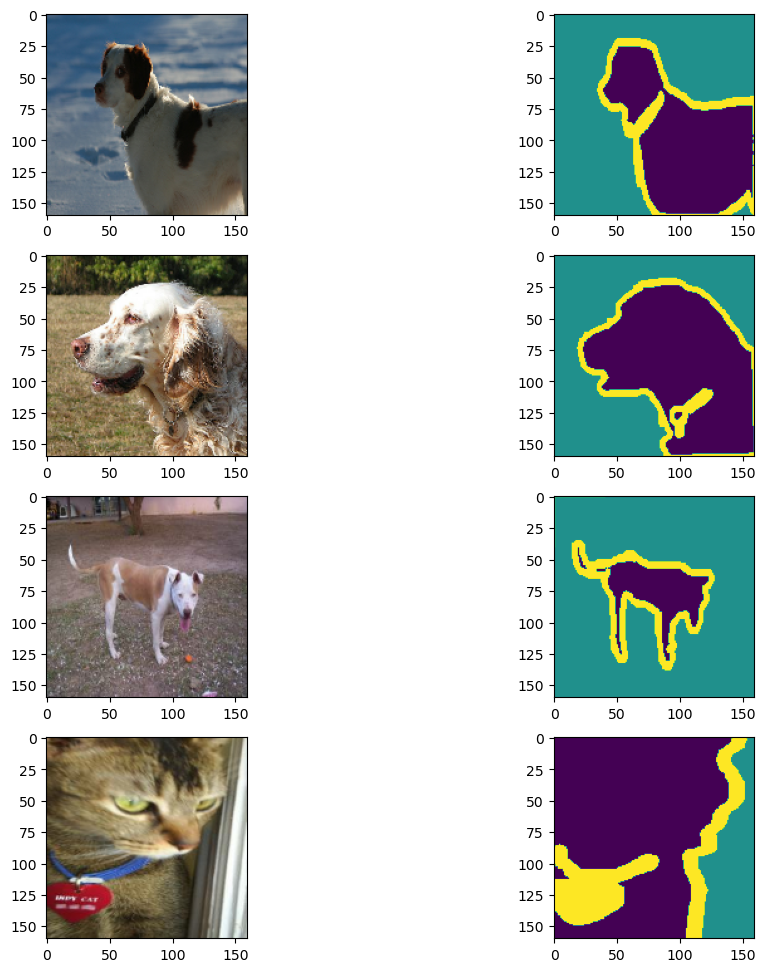

In [17]:
plt.figure(figsize=(12, 12))
for data in train_ds.take(1):
    imgs = data[0]
    labels = data[1]
    for i in range(0, 8, 2):
        plt.subplot(4, 2, i + 1)
        plt.imshow(imgs[i].numpy())
        plt.subplot(4, 2, i + 2)
        plt.imshow(labels[i].numpy() / 2)

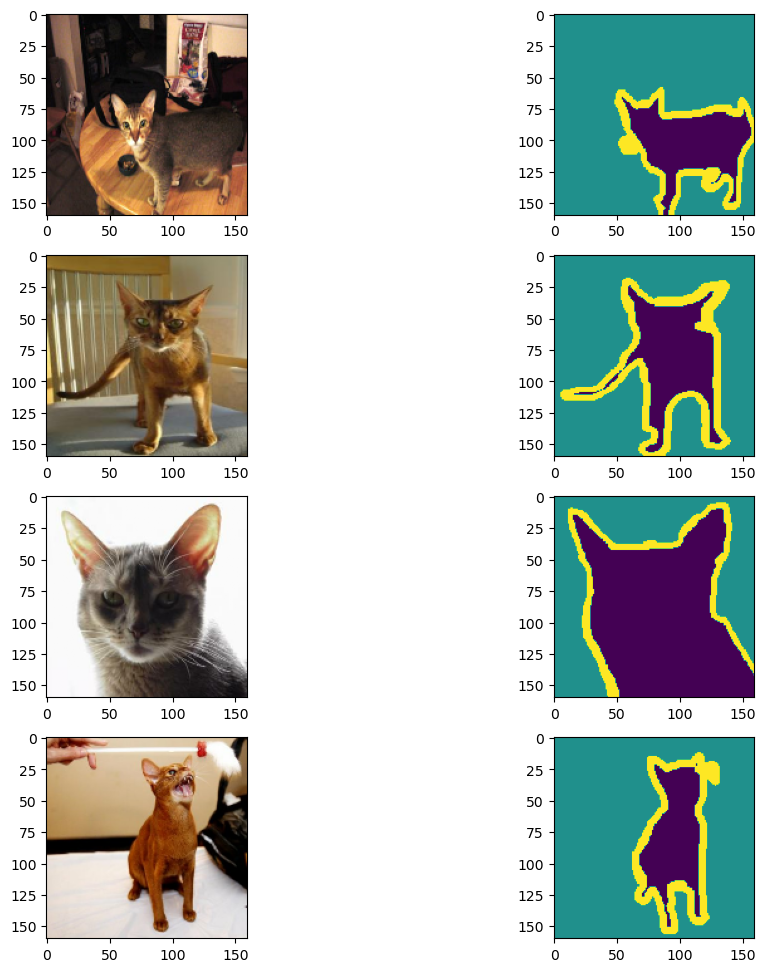

In [18]:
plt.figure(figsize=(12, 12))
for data in test_ds.take(1):
    imgs = data[0]
    labels = data[1]
    for i in range(0, 8, 2):
        plt.subplot(4, 2, i + 1)
        plt.imshow(imgs[i].numpy())
        plt.subplot(4, 2, i + 2)
        plt.imshow(labels[i].numpy() / 2)

In [19]:
def build_upsample_block(filters, kernel_size, stride, padding, name):
    block = Sequential([
        layers.Conv2D(filters, kernel_size, strides=stride, padding=padding),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(filters, kernel_size, strides=stride, padding=padding),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2DTranspose(filters // 2, kernel_size=2, strides=2, padding="same")
    ], name)
    return block


def build_conv_block(filters, kernel_size, stride, padding, name):
    block = Sequential([
        layers.Conv2D(filters, kernel_size, strides=stride, padding=padding),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(filters, kernel_size, strides=stride, padding=padding),
        layers.BatchNormalization(),
        layers.Activation("relu"),
    ], name)
    return block


def build_model():
    inputs = layers.Input(shape=(160, 160, 3))
    
    # down sampling
    d1 = build_conv_block(64, 3, 1, "same", "down_block1")(inputs)   # 160
    d2 = layers.MaxPool2D(pool_size=2, strides=2)(d1)   # 80
    d2 = build_conv_block(128, 3, 1, "same", "down_blcok2")(d2)   # 80
    d3 = layers.MaxPool2D(pool_size=2, strides=2)(d2)   # 40
    d3 = build_conv_block(256, 3, 1, "same", "down_block3")(d3)   # 40
    d4 = layers.MaxPool2D(pool_size=2, strides=2)(d3)   # 20
    
    u1 = build_upsample_block(512, 3, 1, "same", "up_block1")(d4)   # 40
    u1 = layers.Concatenate()([u1, d3])
    u2 = build_upsample_block(256, 3, 1, "same", "up_block2")(u1)   # 80
    u2 = layers.Concatenate()([u2, d2])
    u3 = build_upsample_block(128, 3, 1, "same", "up_blcok3")(u2)   # 160
    out = layers.Conv2D(3, 1, padding="same", activation="softmax")(u3)
    return Model(inputs, out)
    

In [20]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 down_block1 (Sequential)       (None, 160, 160, 64  39232       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 80, 80, 64)  0           ['down_block1[0][0]']            
                                                                                            

In [21]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_ds, validation_data=test_ds, epochs=NUM_EPOCHS)

Epoch 1/50
 16/115 [===>..........................] - ETA: 19s - loss: 0.8730 - accuracy: 0.5958

Corrupt JPEG data: premature end of data segment


 23/115 [=====>........................] - ETA: 18s - loss: 0.8271 - accuracy: 0.6238

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 58s 433ms/step - loss: 0.6422 - accuracy: 0.7304 - val_loss: 1.2685 - val_accuracy: 0.6674
Epoch 2/50
  3/115 [..............................] - ETA: 22s - loss: 0.5277 - accuracy: 0.7993

Corrupt JPEG data: premature end of data segment


 15/115 [==>...........................] - ETA: 19s - loss: 0.5169 - accuracy: 0.7976

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 37s 318ms/step - loss: 0.4922 - accuracy: 0.8069 - val_loss: 0.8925 - val_accuracy: 0.7093
Epoch 3/50
 37/115 [========>.....................] - ETA: 15s - loss: 0.4311 - accuracy: 0.8320

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 56/115 [=============>................] - ETA: 11s - loss: 0.4324 - accuracy: 0.8314

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 315ms/step - loss: 0.4229 - accuracy: 0.8349 - val_loss: 0.7523 - val_accuracy: 0.7491
Epoch 4/50
 84/115 [====================>.........] - ETA: 6s - loss: 0.3978 - accuracy: 0.8445

Corrupt JPEG data: premature end of data segment


104/115 [==========================>...] - ETA: 2s - loss: 0.3953 - accuracy: 0.8456

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 314ms/step - loss: 0.3925 - accuracy: 0.8468 - val_loss: 0.4870 - val_accuracy: 0.8140
Epoch 5/50
 78/115 [===================>..........] - ETA: 7s - loss: 0.3664 - accuracy: 0.8571

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 86/115 [=====================>........] - ETA: 5s - loss: 0.3653 - accuracy: 0.8577

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.3663 - accuracy: 0.8573 - val_loss: 0.4023 - val_accuracy: 0.8465
Epoch 6/50
  8/115 [=>............................] - ETA: 21s - loss: 0.3668 - accuracy: 0.8576

Corrupt JPEG data: premature end of data segment


 43/115 [==========>...................] - ETA: 14s - loss: 0.3497 - accuracy: 0.8640

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 313ms/step - loss: 0.3464 - accuracy: 0.8656 - val_loss: 0.5021 - val_accuracy: 0.8075
Epoch 7/50
 43/115 [==========>...................] - ETA: 14s - loss: 0.3327 - accuracy: 0.8690

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 75/115 [==================>...........] - ETA: 7s - loss: 0.3298 - accuracy: 0.8707

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 314ms/step - loss: 0.3326 - accuracy: 0.8702 - val_loss: 0.3726 - val_accuracy: 0.8609
Epoch 8/50
 35/115 [========>.....................] - ETA: 15s - loss: 0.3253 - accuracy: 0.8723

Corrupt JPEG data: premature end of data segment


111/115 [===========================>..] - ETA: 0s - loss: 0.3192 - accuracy: 0.8755

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 314ms/step - loss: 0.3183 - accuracy: 0.8758 - val_loss: 0.3550 - val_accuracy: 0.8650
Epoch 9/50
 23/115 [=====>........................] - ETA: 18s - loss: 0.3055 - accuracy: 0.8799

Corrupt JPEG data: premature end of data segment


110/115 [===========================>..] - ETA: 0s - loss: 0.2992 - accuracy: 0.8832

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 37s 319ms/step - loss: 0.3003 - accuracy: 0.8829 - val_loss: 0.3798 - val_accuracy: 0.8509
Epoch 10/50
 12/115 [==>...........................] - ETA: 20s - loss: 0.2936 - accuracy: 0.8874

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


109/115 [===========================>..] - ETA: 1s - loss: 0.2876 - accuracy: 0.8885

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 43s 379ms/step - loss: 0.2882 - accuracy: 0.8881 - val_loss: 0.4576 - val_accuracy: 0.8429
Epoch 11/50
 46/115 [===========>..................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8882

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 61/115 [==============>...............] - ETA: 10s - loss: 0.2843 - accuracy: 0.8893

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 314ms/step - loss: 0.2832 - accuracy: 0.8895 - val_loss: 0.3645 - val_accuracy: 0.8618
Epoch 12/50
 18/115 [===>..........................] - ETA: 19s - loss: 0.2643 - accuracy: 0.8971

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


111/115 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.8954

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 37s 319ms/step - loss: 0.2681 - accuracy: 0.8953 - val_loss: 0.3334 - val_accuracy: 0.8742
Epoch 13/50
  7/115 [>.............................] - ETA: 21s - loss: 0.2538 - accuracy: 0.8996

Corrupt JPEG data: premature end of data segment


 16/115 [===>..........................] - ETA: 19s - loss: 0.2595 - accuracy: 0.8981

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.2578 - accuracy: 0.8993 - val_loss: 0.3253 - val_accuracy: 0.8760
Epoch 14/50
  1/115 [..............................] - ETA: 34s - loss: 0.2279 - accuracy: 0.9112

Corrupt JPEG data: premature end of data segment


 81/115 [====================>.........] - ETA: 6s - loss: 0.2433 - accuracy: 0.9045

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.2463 - accuracy: 0.9036 - val_loss: 0.3980 - val_accuracy: 0.8565
Epoch 15/50
 81/115 [====================>.........] - ETA: 6s - loss: 0.2386 - accuracy: 0.9061

Corrupt JPEG data: premature end of data segment


110/115 [===========================>..] - ETA: 0s - loss: 0.2383 - accuracy: 0.9061

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 315ms/step - loss: 0.2395 - accuracy: 0.9058 - val_loss: 0.3163 - val_accuracy: 0.8812
Epoch 16/50
 19/115 [===>..........................] - ETA: 19s - loss: 0.2199 - accuracy: 0.9128

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 29/115 [======>.......................] - ETA: 17s - loss: 0.2175 - accuracy: 0.9139

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 314ms/step - loss: 0.2241 - accuracy: 0.9116 - val_loss: 0.3423 - val_accuracy: 0.8733
Epoch 17/50
 23/115 [=====>........................] - ETA: 18s - loss: 0.2147 - accuracy: 0.9164

Corrupt JPEG data: premature end of data segment


 51/115 [============>.................] - ETA: 12s - loss: 0.2092 - accuracy: 0.9181

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 380ms/step - loss: 0.2111 - accuracy: 0.9170 - val_loss: 0.3230 - val_accuracy: 0.8831
Epoch 18/50
 35/115 [========>.....................] - ETA: 15s - loss: 0.2012 - accuracy: 0.9199

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 87/115 [=====================>........] - ETA: 5s - loss: 0.2013 - accuracy: 0.9200

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 37s 322ms/step - loss: 0.2019 - accuracy: 0.9198 - val_loss: 0.3200 - val_accuracy: 0.8829
Epoch 19/50
 85/115 [=====================>........] - ETA: 5s - loss: 0.1896 - accuracy: 0.9240

Corrupt JPEG data: premature end of data segment


101/115 [=========================>....] - ETA: 2s - loss: 0.1915 - accuracy: 0.9234

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.1936 - accuracy: 0.9227 - val_loss: 0.3288 - val_accuracy: 0.8837
Epoch 20/50
 40/115 [=========>....................] - ETA: 14s - loss: 0.1864 - accuracy: 0.9253

Corrupt JPEG data: premature end of data segment


 71/115 [=================>............] - ETA: 8s - loss: 0.1836 - accuracy: 0.9263

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 43s 379ms/step - loss: 0.1884 - accuracy: 0.9246 - val_loss: 0.4095 - val_accuracy: 0.8610
Epoch 21/50
 16/115 [===>..........................] - ETA: 19s - loss: 0.1717 - accuracy: 0.9308

Corrupt JPEG data: premature end of data segment


 39/115 [=========>....................] - ETA: 15s - loss: 0.1765 - accuracy: 0.9287

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.1796 - accuracy: 0.9276 - val_loss: 0.3256 - val_accuracy: 0.8865
Epoch 22/50
  4/115 [>.............................] - ETA: 22s - loss: 0.1721 - accuracy: 0.9310

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 43/115 [==========>...................] - ETA: 14s - loss: 0.1675 - accuracy: 0.9321

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 43s 378ms/step - loss: 0.1663 - accuracy: 0.9325 - val_loss: 0.3399 - val_accuracy: 0.8832
Epoch 23/50
 19/115 [===>..........................] - ETA: 19s - loss: 0.1542 - accuracy: 0.9367

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 54/115 [=============>................] - ETA: 12s - loss: 0.1575 - accuracy: 0.9355

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 380ms/step - loss: 0.1607 - accuracy: 0.9345 - val_loss: 0.3422 - val_accuracy: 0.8856
Epoch 24/50
  9/115 [=>............................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9402

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 12/115 [==>...........................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9396

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 43s 379ms/step - loss: 0.1592 - accuracy: 0.9350 - val_loss: 0.3458 - val_accuracy: 0.8843
Epoch 25/50
 32/115 [=======>......................] - ETA: 16s - loss: 0.1519 - accuracy: 0.9380

Corrupt JPEG data: premature end of data segment


 65/115 [===============>..............] - ETA: 9s - loss: 0.1498 - accuracy: 0.9386 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 312ms/step - loss: 0.1508 - accuracy: 0.9381 - val_loss: 0.3573 - val_accuracy: 0.8845
Epoch 26/50
 59/115 [==============>...............] - ETA: 11s - loss: 0.1340 - accuracy: 0.9442

Corrupt JPEG data: premature end of data segment


 62/115 [===============>..............] - ETA: 10s - loss: 0.1339 - accuracy: 0.9442

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.1342 - accuracy: 0.9441 - val_loss: 0.3841 - val_accuracy: 0.8919
Epoch 27/50
 44/115 [==========>...................] - ETA: 14s - loss: 0.1264 - accuracy: 0.9469

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 88/115 [=====================>........] - ETA: 5s - loss: 0.1252 - accuracy: 0.9473

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.1257 - accuracy: 0.9472 - val_loss: 0.3765 - val_accuracy: 0.8881
Epoch 28/50
 43/115 [==========>...................] - ETA: 14s - loss: 0.1262 - accuracy: 0.9471

Corrupt JPEG data: premature end of data segment


104/115 [==========================>...] - ETA: 2s - loss: 0.1245 - accuracy: 0.9476

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 315ms/step - loss: 0.1245 - accuracy: 0.9477 - val_loss: 0.3882 - val_accuracy: 0.8925
Epoch 29/50
 10/115 [=>............................] - ETA: 21s - loss: 0.1169 - accuracy: 0.9510

Corrupt JPEG data: premature end of data segment


 86/115 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9496

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 315ms/step - loss: 0.1217 - accuracy: 0.9488 - val_loss: 0.5373 - val_accuracy: 0.8661
Epoch 30/50
 37/115 [========>.....................] - ETA: 15s - loss: 0.1117 - accuracy: 0.9527

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


105/115 [==========================>...] - ETA: 1s - loss: 0.1127 - accuracy: 0.9523

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.1145 - accuracy: 0.9516 - val_loss: 0.5480 - val_accuracy: 0.8628
Epoch 31/50
 70/115 [=================>............] - ETA: 8s - loss: 0.1161 - accuracy: 0.9509

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 89/115 [======================>.......] - ETA: 5s - loss: 0.1156 - accuracy: 0.9511

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 315ms/step - loss: 0.1168 - accuracy: 0.9506 - val_loss: 0.4274 - val_accuracy: 0.8829
Epoch 32/50
 40/115 [=========>....................] - ETA: 14s - loss: 0.1115 - accuracy: 0.9527

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 92/115 [=======================>......] - ETA: 4s - loss: 0.1069 - accuracy: 0.9545

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 380ms/step - loss: 0.1064 - accuracy: 0.9547 - val_loss: 0.3939 - val_accuracy: 0.8946
Epoch 33/50
 61/115 [==============>...............] - ETA: 10s - loss: 0.0987 - accuracy: 0.9577

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


105/115 [==========================>...] - ETA: 1s - loss: 0.0985 - accuracy: 0.9578

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 43s 378ms/step - loss: 0.0984 - accuracy: 0.9578 - val_loss: 0.3767 - val_accuracy: 0.8970
Epoch 34/50
  8/115 [=>............................] - ETA: 21s - loss: 0.0969 - accuracy: 0.9586

Corrupt JPEG data: premature end of data segment


 61/115 [==============>...............] - ETA: 10s - loss: 0.0932 - accuracy: 0.9599

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 44s 379ms/step - loss: 0.0932 - accuracy: 0.9599 - val_loss: 0.3816 - val_accuracy: 0.8991
Epoch 35/50
 36/115 [========>.....................] - ETA: 15s - loss: 0.0899 - accuracy: 0.9612

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 46/115 [===========>..................] - ETA: 13s - loss: 0.0896 - accuracy: 0.9614

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 37s 321ms/step - loss: 0.0989 - accuracy: 0.9579 - val_loss: 0.5999 - val_accuracy: 0.8609
Epoch 36/50
  4/115 [>.............................] - ETA: 22s - loss: 0.1122 - accuracy: 0.9532

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  9/115 [=>............................] - ETA: 21s - loss: 0.1114 - accuracy: 0.9534

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.1181 - accuracy: 0.9507 - val_loss: 0.5766 - val_accuracy: 0.8390
Epoch 37/50
 41/115 [=========>....................] - ETA: 14s - loss: 0.1087 - accuracy: 0.9540

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 48/115 [===========>..................] - ETA: 13s - loss: 0.1075 - accuracy: 0.9545

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 43s 379ms/step - loss: 0.1076 - accuracy: 0.9547 - val_loss: 0.4088 - val_accuracy: 0.8791
Epoch 38/50
  8/115 [=>............................] - ETA: 21s - loss: 0.1017 - accuracy: 0.9569

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 46/115 [===========>..................] - ETA: 13s - loss: 0.0940 - accuracy: 0.9598

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 313ms/step - loss: 0.0927 - accuracy: 0.9604 - val_loss: 0.3794 - val_accuracy: 0.8991
Epoch 39/50
 57/115 [=============>................] - ETA: 11s - loss: 0.0815 - accuracy: 0.9648

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 59/115 [==============>...............] - ETA: 11s - loss: 0.0817 - accuracy: 0.9647

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.0827 - accuracy: 0.9643 - val_loss: 0.4317 - val_accuracy: 0.8973
Epoch 40/50
 14/115 [==>...........................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9671

Corrupt JPEG data: premature end of data segment


 36/115 [========>.....................] - ETA: 15s - loss: 0.0763 - accuracy: 0.9669

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 313ms/step - loss: 0.0768 - accuracy: 0.9667 - val_loss: 0.4216 - val_accuracy: 0.8994
Epoch 41/50
 45/115 [==========>...................] - ETA: 14s - loss: 0.0730 - accuracy: 0.9684

Corrupt JPEG data: premature end of data segment


 77/115 [===================>..........] - ETA: 7s - loss: 0.0731 - accuracy: 0.9684

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 313ms/step - loss: 0.0735 - accuracy: 0.9682 - val_loss: 0.4296 - val_accuracy: 0.8988
Epoch 42/50
  6/115 [>.............................] - ETA: 22s - loss: 0.0725 - accuracy: 0.9687

Corrupt JPEG data: premature end of data segment


 12/115 [==>...........................] - ETA: 21s - loss: 0.0708 - accuracy: 0.9694

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 37s 319ms/step - loss: 0.0706 - accuracy: 0.9695 - val_loss: 0.4523 - val_accuracy: 0.8984
Epoch 43/50
 33/115 [=======>......................] - ETA: 16s - loss: 0.0670 - accuracy: 0.9711

Corrupt JPEG data: premature end of data segment


 72/115 [=================>............] - ETA: 8s - loss: 0.0673 - accuracy: 0.9710

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 37s 319ms/step - loss: 0.0682 - accuracy: 0.9706 - val_loss: 0.4933 - val_accuracy: 0.8953
Epoch 44/50
 57/115 [=============>................] - ETA: 11s - loss: 0.0660 - accuracy: 0.9716

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 58/115 [==============>...............] - ETA: 11s - loss: 0.0661 - accuracy: 0.9716

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 379ms/step - loss: 0.0690 - accuracy: 0.9703 - val_loss: 0.5548 - val_accuracy: 0.8863
Epoch 45/50
 42/115 [=========>....................] - ETA: 14s - loss: 0.0684 - accuracy: 0.9706

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 58/115 [==============>...............] - ETA: 11s - loss: 0.0677 - accuracy: 0.9709

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 37s 321ms/step - loss: 0.0672 - accuracy: 0.9711 - val_loss: 0.4932 - val_accuracy: 0.8958
Epoch 46/50
  3/115 [..............................] - ETA: 22s - loss: 0.0619 - accuracy: 0.9734

Corrupt JPEG data: premature end of data segment


 95/115 [=======================>......] - ETA: 3s - loss: 0.0613 - accuracy: 0.9736

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 37s 318ms/step - loss: 0.0614 - accuracy: 0.9736 - val_loss: 0.4874 - val_accuracy: 0.8980
Epoch 47/50
 17/115 [===>..........................] - ETA: 19s - loss: 0.0570 - accuracy: 0.9755

Corrupt JPEG data: premature end of data segment


 37/115 [========>.....................] - ETA: 15s - loss: 0.0575 - accuracy: 0.9753

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 315ms/step - loss: 0.0587 - accuracy: 0.9748 - val_loss: 0.5126 - val_accuracy: 0.8983
Epoch 48/50
  4/115 [>.............................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9749

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 17/115 [===>..........................] - ETA: 19s - loss: 0.0552 - accuracy: 0.9764

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 44s 380ms/step - loss: 0.0575 - accuracy: 0.9753 - val_loss: 0.5258 - val_accuracy: 0.8950
Epoch 49/50
  5/115 [>.............................] - ETA: 21s - loss: 0.0579 - accuracy: 0.9752

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 70/115 [=================>............] - ETA: 8s - loss: 0.0567 - accuracy: 0.9757

Corrupt JPEG data: premature end of data segment


115/115 [==============================] - 36s 317ms/step - loss: 0.0574 - accuracy: 0.9754 - val_loss: 0.5218 - val_accuracy: 0.8937
Epoch 50/50
  1/115 [..............................] - ETA: 33s - loss: 0.0530 - accuracy: 0.9773

Corrupt JPEG data: premature end of data segment


 53/115 [============>.................] - ETA: 12s - loss: 0.0554 - accuracy: 0.9762

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 [==============================] - 36s 315ms/step - loss: 0.0556 - accuracy: 0.9762 - val_loss: 0.5367 - val_accuracy: 0.8968


In [22]:
model.save("/kaggle/working/oxford_pet.h5")